In [1]:
%matplotlib widget

In [2]:
import numpy as np
import string
import matplotlib.pyplot as plt
import itertools
from scipy.stats import entropy
from tqdm import tqdm
import flammkuchen as fl
from pathlib import Path
from ipywidgets import IntSlider, interact, fixed, Text
import pandas as pd
import operator

In [3]:
#Load word lists
with open('wordle-allowed-guesses.txt') as f:
    valid = f.read().split('\n')
    
with open('wordle-answers-alphabetical.txt') as f:
    answers = f.read().split('\n')

In [4]:
#Make list of letters
letters = list(string.ascii_lowercase)

We first take a look at what the most common letters are within the pool of valid words:

In [5]:
#Check letter frequencies among accepted guesses
letter_freq = np.zeros(len(letters))

for i, letter in enumerate(letters):
    for word in valid:
        if letter in word:
            letter_freq[i]+=1
        else:
            pass
        
freq_sort = np.argsort(letter_freq)[::-1]

Text(0, 0.5, 'Found in (% of words)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
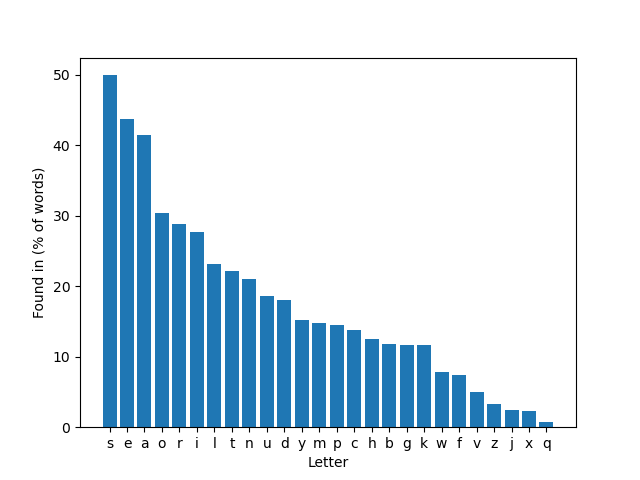

In [6]:
letter_ratio = letter_freq/len(valid)*100

plt.figure()
plt.bar([letters[i] for i in freq_sort], [letter_ratio[i] for i in freq_sort])

plt.xlabel('Letter')
plt.ylabel('Found in (% of words)')

In [7]:
#Make functions for scoring guesses
def find_letter_idxs(letter, sol):
    idxs = np.nonzero(letter == np.array(list(sol)))
    
    return idxs[0]

def score_word(guess, sol):
    guess_letters = list(guess)
    sol_letters = list(sol)
    score = np.zeros(5, int)
    
    accounted_idxs = []
    
    for i, letter in enumerate(guess_letters):
        if sol_letters[i] == letter:
            score[i]=2
            accounted_idxs.append(i)

    for i, letter in enumerate(guess_letters):  
        if letter in sol_letters and score[i] != 2:
            letter_idxs = find_letter_idxs(letter, sol)
            
            for pos in letter_idxs:
                if pos not in accounted_idxs:
                    score[i]=1
                    accounted_idxs.append(pos)
                    break
        else:
            pass
        
    return score

In [8]:
#Make list with all possible scoring patterns
base_patterns = list(itertools.combinations_with_replacement([0,1,2],5))

all_patterns = []

for pattern in base_patterns:
    all_patterns.append(list(itertools.permutations(pattern)))
    
all_patterns = [item for sublist in all_patterns for item in sublist]

patterns = list(dict.fromkeys(all_patterns))

In [9]:
#Function to calculate entroy for words in a list
def calculate_entropy(guess_pool, solution_pool):
    
    entropies_dict = {}
    scores_dict = {}

    for guess in guess_pool:

        scores = []
        for answer in solution_pool:
            scores.append(score_word(guess, answer))

        scores_arr = np.array(scores)

        #Store patterns and their probabilities
        score_patterns, score_counts = np.unique(scores_arr, axis=0, return_counts=True)
        score_sort = np.argsort(score_counts)[::-1]

        score_patterns_str = np.array([''.join(str(i) for i in list(pat)) for pat in score_patterns])

        scores_dict[guess] = [score_patterns, score_counts]

        #Calculate and stroe entropy
        entropies_dict[guess] = entropy(score_counts, base=2)
        
    return entropies_dict, scores_dict

In [14]:
#Load or calculate the initial average entropy of every word in the valid pool:
try:
    #Load results
    entropies_dict = fl.load(Path('entropies_dict.h5'))
    scores_dict = fl.load(Path('scores_dict.h5'))
    
except OSError:
    #Calculate
    calculate_entropy([valid + answers], [valid + answers])
    
    #Store results
    fl.save(Path('entropies_dict.h5'), entropies_dict)
    fl.save(Path('scores_dict.h5'),scores_dict)

In [15]:
cols = ['darkgray', 'gold', 'green']

def pattern_to_string(pattern):
    return ''.join(str(i) for i in list(pattern))

def plot_pattern_score(guess):
    
    try:
    
        fig, axes = plt.subplots(1,2, figsize=(8,4))

        score_patterns, score_counts = scores_dict[guess] 
        entropy = entropies_dict[guess]

        score_sort = np.argsort(score_counts)[::-1]
        score_patterns_str = np.array([pattern_to_string(pattern) for pattern in score_patterns]) 

        axes[0].bar(np.arange(score_patterns.shape[0]), score_counts[score_sort]/len(answers))

        axes[0].set_xticks(np.arange(score_counts.shape[0]))
        axes[0].set_xticklabels(score_patterns_str[score_sort], rotation=90)
        axes[0].set_xlim(-.5,10.5)

        axes[0].set_ylabel('Score pattern probability')

        counts_norm = score_counts/np.sum(score_counts)
        order = np.argsort(counts_norm)[::-1]
        score_patterns_ord = score_patterns[order]
        counts_norm_ord = counts_norm[order]

        for let in range(5):
            for i, (pat, count) in enumerate(zip(score_patterns_ord[:, let], counts_norm_ord)):
                axes[1].bar(let, count, bottom=np.sum(counts_norm_ord[:i]), color=cols[pat])


        axes[1].set_ylabel('Pattern probability')
        axes[1].set_xticks(range(5))
        axes[1].set_xticklabels([x.upper() for x in guess])

        plt.suptitle('{} - {:.2f} bits'.format(guess.upper(), entropy))
        plt.tight_layout();
        
    except KeyError:
        pass

In [16]:
#Get a list of ordered words (with decreasing entropy)
entropy_order = np.argsort([entropies_dict[word] for word in (valid+answers)])[::-1]
guesses_ordered = [(valid+answers)[i] for i in entropy_order]
guesses_ordered[:10]

['soare',
 'roate',
 'raise',
 'raile',
 'reast',
 'slate',
 'crate',
 'salet',
 'irate',
 'trace']

Make some visualization to see how words compare to each other:

interactive(children=(Text(value='', description='Guess word:', placeholder='Type something'), Output()), _dom…

<function __main__.plot_pattern_score(guess)>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
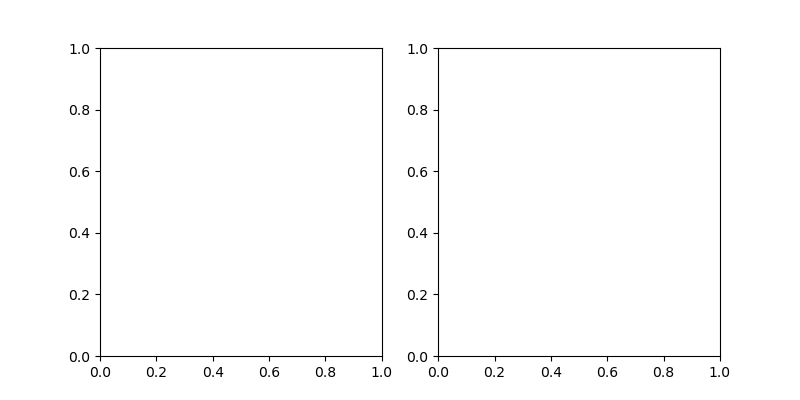

In [17]:
interact(plot_pattern_score,
        guess = Text(placeholder='Type something', description='Guess word:'), continuous_update=False)

In [19]:
#Function to remove invalid guesses from solution pool
def modify_word_list(word, letter_status, sol_pool):
    
    word_list = sol_pool
    
    new_word_list = []
    correct_letters = []
    present_letters = []
    
    for i in range(len(word)):
        if letter_status[i] == 2:
            correct_letters.append(word[i])
            for w in word_list:
                if w[i] == word[i]:
                    new_word_list.append(w)
            word_list = new_word_list
            new_word_list = []
    for i in range(len(word)):
        if letter_status[i] == 1:
            present_letters.append(word[i])
            for w in word_list:
                if word[i] in w and word[i] != w[i]:
                    new_word_list.append(w)
            word_list = new_word_list
            new_word_list = []
    for i in range(len(word)):
        if (
            letter_status[i] == 0
            and word[i] not in correct_letters
            and word[i] not in present_letters
        ):
            for w in word_list:
                if word[i] not in w:
                    new_word_list.append(w)
            word_list = new_word_list
            new_word_list = []

    return word_list


In [20]:
def return_best_guess(entropies_dict):
    entropy_order = np.argsort([entropies_dict[word] for word in entropies_dict.keys()])[::-1]
    guesses_ordered = [list(entropies_dict.keys())[i] for i in entropy_order]
    
    return guesses_ordered

Here we start dealing with the interaction with the webpage:

In [21]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium import webdriver

In [22]:
def start_game(driver, mode='free'):
    driver.get("http://sedecordle.com")
    elem1 = driver.find_element(By.ID, mode)
    elem1.click()

In [23]:
def introduce_word(driver, word):
    for letter in word:
        elem = driver.find_element(By.ID, letter)
        elem.click()
    elem = driver.find_element(By.ID, "enter2")
    elem.click()

In [24]:
def evaluate_word(driver, word_n, guess_n):
    score = []

    for i in range(5):
        boxstyle = driver.find_element(By.ID, "box{},{},{}".format(word_n+1, guess_n+1, i+1)).get_attribute("style")

        if "(24, " in boxstyle:
            score.append(0)
        if "(255, " in boxstyle:
            score.append(1)
        if "(0, " in boxstyle:
            score.append(2)
            
    return score

In [26]:
#Main loop
n_words = 16
unsolved_words = [n for n in range(n_words)]
attempt = 0

solver = {word:{} for word in range(n_words)}

#Initialize browser interface
driver = webdriver.Chrome(service=Service())

#Open sedecordle website and start game
start_game(driver)

#Introduce first guess
guess = return_best_guess(entropies_dict)[0]
introduce_word(driver, guess)

#Evaluate results
for word in range(16):
    score = evaluate_word(driver, word, attempt)
    sol_pool = modify_word_list(guess, score, answers)
    solver[word] = sol_pool
attempt +=1

print([len(solver[word]) for word in range(n_words)])
    
while len(unsolved_words)!=0:
    print('While loop {}'.format(attempt))
    
    #Find word with less options
    options_per_word = [len(solver[word]) for word in range(n_words)]
    words_sorted = np.argsort(options_per_word)
    
    for word in words_sorted:
        if word not in unsolved_words:
            continue
        else:
            next_word = word
            break
    print('trying to solve word {}'.format(next_word))

    #Calculate next best guess and introduce
    if next_word in unsolved_words:
        entropies, scores = calculate_entropy(solver[next_word], solver[next_word])
        guess = return_best_guess(entropies)[0]
        introduce_word(driver, guess)
    else:
        pass
        
    for word in range(16):
        score = evaluate_word(driver, word, attempt)
        
        if score == [2,2,2,2,2]:
            unsolved_words.remove(word)
            print('Word {} solved!!'.format(word))
        else:
            sol_pool = modify_word_list(guess, score, solver[word])
            solver[word] = sol_pool
        
    attempt +=1
    print([len(solver[word]) for word in range(n_words)])

print('Sedecordle solved!!')

[4, 183, 138, 19, 33, 13, 138, 138, 9, 87, 117, 59, 61, 44, 87, 117]
While loop 1
trying to solve word 0
Word 0 solved!!
[4, 117, 92, 6, 20, 4, 92, 92, 8, 58, 83, 41, 35, 29, 9, 83]
While loop 2
trying to solve word 5
[0, 52, 4, 5, 15, 1, 1, 13, 2, 26, 30, 8, 13, 7, 4, 6]
While loop 3
trying to solve word 5
Word 5 solved!!
[0, 19, 4, 1, 13, 1, 1, 1, 2, 15, 17, 4, 10, 6, 3, 1]
While loop 4
trying to solve word 3
Word 3 solved!!
[0, 19, 4, 1, 13, 0, 1, 1, 2, 15, 17, 3, 10, 6, 2, 1]
While loop 5
trying to solve word 6
Word 6 solved!!
[0, 7, 1, 0, 2, 0, 1, 1, 1, 13, 10, 1, 8, 2, 1, 1]
While loop 6
trying to solve word 2
Word 2 solved!!
[0, 7, 1, 0, 1, 0, 0, 1, 1, 10, 10, 1, 6, 2, 1, 1]
While loop 7
trying to solve word 4
Word 4 solved!!
[0, 6, 0, 0, 1, 0, 0, 1, 1, 8, 8, 1, 5, 2, 1, 1]
While loop 8
trying to solve word 7
Word 7 solved!!
[0, 6, 0, 0, 1, 0, 0, 1, 1, 8, 8, 1, 5, 2, 1, 1]
While loop 9
trying to solve word 8
Word 8 solved!!
[0, 3, 0, 0, 1, 0, 0, 0, 1, 2, 1, 1, 3, 2, 1, 1]
While 

AttributeError: 'NoneType' object has no attribute 'get_attribute'

In [ ]:
#Make some stats
solved = 0
atts = []

for i in tqdm(range(100)):

    #Main loop
    n_words = 16
    unsolved_words = [n for n in range(n_words)]
    attempt = 0

    solver = {word:{} for word in range(n_words)}

    #Initialize browser interface
    driver = webdriver.Chrome(service=Service())

    #Open sedecordle website and start game
    start_game(driver)

    #Introduce first guess
    guess = return_best_guess(entropies_dict)[0]
    introduce_word(driver, guess)

    #Evaluate results
    for word in range(16):
        score = evaluate_word(driver, word, attempt)
        sol_pool = modify_word_list(guess, score, answers)
        solver[word] = sol_pool
    attempt +=1

    while len(unsolved_words)!=0:

        #Find word with less options
        options_per_word = [len(solver[word]) for word in range(n_words)]
        words_sorted = np.argsort(options_per_word)

        for word in words_sorted:
            if word not in unsolved_words:
                continue
            else:
                next_word = word
                break

        #Calculate next best guess and introduce
        if next_word in unsolved_words:
            entropies, scores = calculate_entropy(solver[next_word], solver[next_word])
            guess = return_best_guess(entropies)[0]
            introduce_word(driver, guess)
        else:
            pass

        for word in range(16):
            score = evaluate_word(driver, word, attempt)

            if score == [2,2,2,2,2]:
                unsolved_words.remove(word)
            else:
                sol_pool = modify_word_list(guess, score, solver[word])
                solver[word] = sol_pool

        attempt +=1
        if attempt == 21:
            break

    if len(unsolved_words)==0:
        solved+=1
    atts.append(attempt)
    driver.quit()


In [27]:
test_run_results = fl.load('test_run_results.h5')

attempts, counts = np.unique(test_run_results['attempts'], return_counts=True)
attempts = np.append(attempts, 22)

counts = np.append(counts, len(test_run_results['attempts'])-test_run_results['solves'])
counts[4] = counts[4] - (len(test_run_results['attempts'])-test_run_results['solves'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
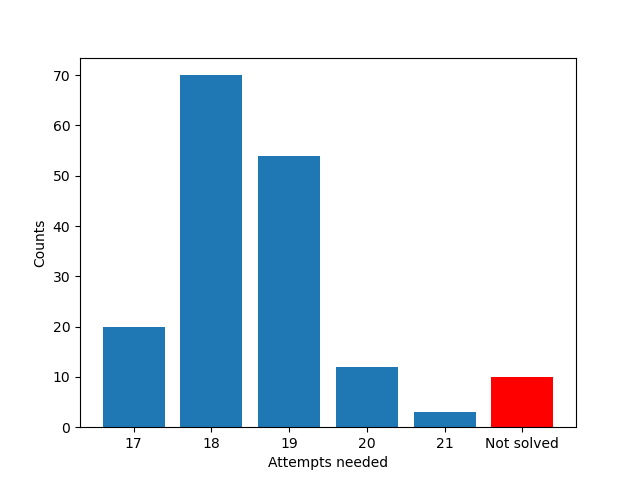

In [28]:
fig, axes = plt.subplots(1,1)
axes.bar(attempts[:-1], counts[:-1])
axes.bar(attempts[-1], counts[-1], color='red')

axes.set_xticks(attempts)
axes.set_xticklabels(list(attempts[:-1])+['Not solved'])
axes.set_xlabel('Attempts needed')
axes.set_ylabel('Counts');